# Brain Tumor Detection

The goal of this project is to be able to detect brain tumors in brain MRI images. To do so we will be creating a *CNN* using *Tensorflow*.

### Import Libraries

In [2]:
import os
import random
import numpy as np
import tensorflow as tf
from cv2 import imread, resize
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dense, Flatten,
                                     RandomFlip, RandomZoom,
                                     RandomContrast, RandomRotation)
import warnings

warnings.filterwarnings("ignore")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.keras.backend.clear_session()

### Define constants

In [3]:
INPUT_PATH = "brain_tumor_dataset"
IMG_SIZE = (256, 256)
EPOCHS = 15
BATCH_SIZE = 32
WORKERS = 32

### Import Images

In [4]:
test_X, test_Y = [], []
train_X, train_Y = [], []
val_X, val_Y = [], []

for i, cond in enumerate(["CLEAN", "TUMOR"]):
    for _set in ["test", "train", "validation"]:
        for img in os.listdir(os.path.join(INPUT_PATH, _set, cond)):
            img = imread(os.path.join(INPUT_PATH, _set, cond, img), 0)
            img = resize(img, IMG_SIZE)
            img = np.dstack([img, img, img])
            img = img.astype("float32") / 255

            if _set == "test":
                test_X.append(img)
                test_Y.append(i)
            elif _set == "train":
                train_X.append(img)
                train_Y.append(i)
            elif _set == "validation":
                val_X.append(img)
                val_Y.append(i)

test_X = np.array(test_X)
test_Y = np.array(test_Y)
train_X = np.array(train_X)
train_Y = np.array(train_Y)
val_X = np.array(val_X)
val_Y = np.array(val_Y)

In [5]:
for _set in ["train", "validation", "test"]:
    n_clean = len(os.listdir(os.path.join(INPUT_PATH, _set, "CLEAN")))
    n_defect = len(os.listdir(os.path.join(INPUT_PATH, _set, "TUMOR")))
    print("Set: {}, normal images: {}, tumors: {}".format(
        _set, n_clean, n_defect))


Set: train, normal images: 59, tumors: 93
Set: validation, normal images: 19, tumors: 31
Set: test, normal images: 20, tumors: 31


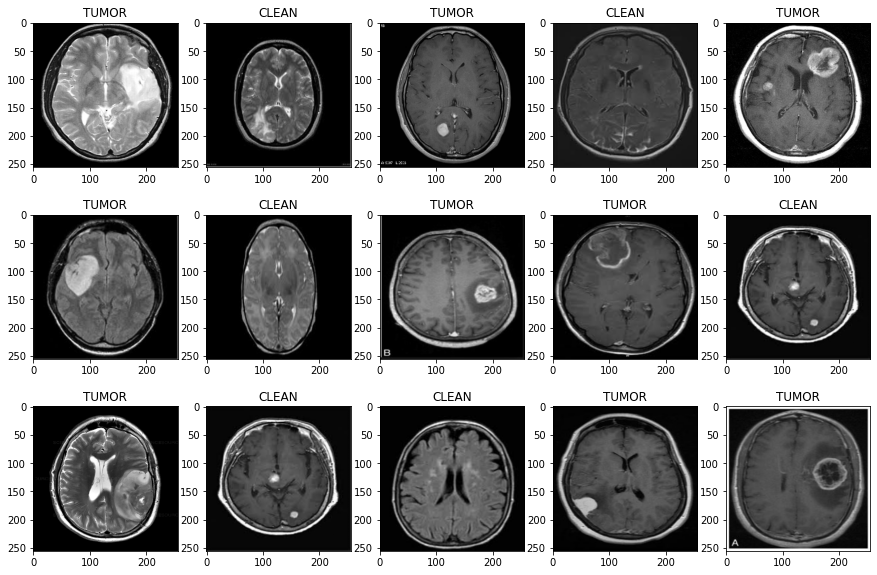

In [6]:
fig, ax = plt.subplots(3, 5, figsize=(15,10))
ax = ax.flatten()
for i in range(15):
    index = random.randrange(0, len(test_X) - 1)
    img = test_X[index]
    label = "CLEAN" if test_Y[index] == 0 else "TUMOR"
    ax[i].imshow(img)
    ax[i].title.set_text(label)

#### Data Augmentation

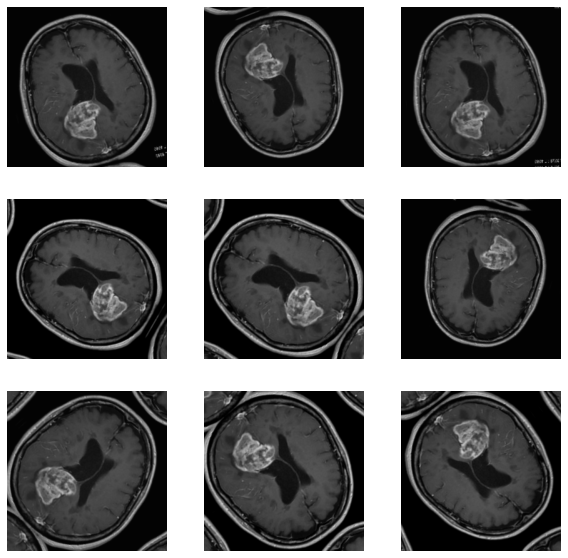

In [9]:
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical", input_shape=(256, 256, 3)),
    RandomZoom(0.1),
    RandomContrast(0.1),
    RandomRotation(0.2)
])

image = np.expand_dims(test_X[-1], 0)

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

### Create Model

In [7]:
layers = [
    data_augmentation,
    Conv2D(16, (3, 3), 1, activation="relu", padding="same"),
    Conv2D(16, (3, 3), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    Conv2D(32, (5, 5), 1, activation="relu", padding="same"),
    Conv2D(32, (5, 5), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    Conv2D(16, (3, 3), 1, activation="relu", padding="same"),
    Conv2D(16, (3, 3), 1, activation="relu", padding="same"),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(1, activation="sigmoid")
]
model = Sequential(layers)

model.compile(optimizer="adam",
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=["accuracy"])


In [8]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 16)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 32)      12832     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      25632     
                                                      

### Train Model

In [9]:
hist = model.fit(x=train_X,
                 y=train_Y,
                 epochs=EPOCHS,
                 validation_data=(val_X, val_Y),
                 batch_size=BATCH_SIZE,
                 workers=WORKERS)

2022-08-10 11:39:49.779189: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 119537664 exceeds 10% of free system memory.


Epoch 1/15


2022-08-10 11:39:53.024110: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2022-08-10 11:39:53.024155: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2022-08-10 11:39:53.024182: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.
2022-08-10 11:39:53.024222: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 25165824 exceeds 10% of free system memory.


5/5 [==============================] - 18s 3s/step - loss: 0.6505 - accuracy: 0.5461 - val_loss: 0.6182 - val_accuracy: 0.6200
Epoch 2/15
5/5 [==============================] - 14s 3s/step - loss: 0.6250 - accuracy: 0.6447 - val_loss: 0.6164 - val_accuracy: 0.7600
Epoch 3/15
5/5 [==============================] - 14s 3s/step - loss: 0.5936 - accuracy: 0.7171 - val_loss: 0.5111 - val_accuracy: 0.8000
Epoch 4/15
5/5 [==============================] - 16s 3s/step - loss: 0.6052 - accuracy: 0.6974 - val_loss: 0.5256 - val_accuracy: 0.7800
Epoch 5/15
5/5 [==============================] - 16s 3s/step - loss: 0.5992 - accuracy: 0.6842 - val_loss: 0.5379 - val_accuracy: 0.7600
Epoch 6/15
5/5 [==============================] - 17s 3s/step - loss: 0.5697 - accuracy: 0.7171 - val_loss: 0.4858 - val_accuracy: 0.7800
Epoch 7/15
5/5 [==============================] - 16s 3s/step - loss: 0.5822 - accuracy: 0.7171 - val_loss: 0.5013 - val_accuracy: 0.7600
Epoch 8/15
5/5 [=============================

### Metrics

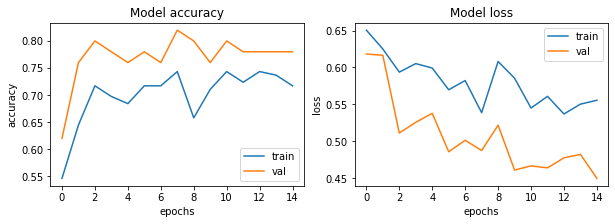

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(["accuracy", "loss"]):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history["val_" + met])

    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])
    
plt.show()

In [11]:
preds = model.predict(test_X)

acc = accuracy_score(test_Y, np.round(preds)) * 100
cm = confusion_matrix(test_Y, np.round(preds))
_, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
f = 2 * precision * recall / (precision + recall)

2/2 [==============================] - 1s 260ms/step


#### Training metrics

In [18]:
print("Accuracy: {}%".format(
    np.round((hist.history["accuracy"][-1]) * 100, 2)))

Accuracy: 71.71%


#### Testing metrics

In [17]:
print("Accuracy: {}%".format(np.round(acc, 2)))
print("Precision: {}%".format(np.round(precision, 2)))
print("Recall: {}%".format(np.round(recall, 2)))
print("F1-Score: {}%".format(np.round(f, 2)))

Accuracy: 86.27%
Precision: 87.5%
Recall: 90.32%
F1-Score: 88.89%


## Manual Testing

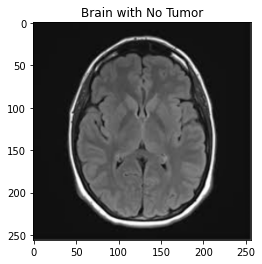

1/1 [==============================] - 0s 37ms/step
No tumor detected [[0.7140175]]


In [16]:
index = random.randrange(0, len(test_X) - 1)
img = test_X[index]
label = test_Y[index]

plt.imshow(img)
if label == 1:
    plt.title("Brain with Tumor")
else:
    plt.title("Brain with No Tumor")
plt.show()
y_hat = model.predict(np.expand_dims(img, 0))

if y_hat < 0.5:
    print("No tumor detected", 1 - y_hat)
else:
    print("Tumor detected", y_hat)
